<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/sklearn_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 평가 (evaluation)

머신러닝 프로세스 구성 : 데이터 가공/변환, 모델 학습/예측, 평가

여러가지 방법으로 예측 성능을 평가할 수 있는데 성능 평가 지표(evaluation Metric)는 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉜다. 

회귀의 경우 대부분 실제 값과 예측값의 오차 평균값에 기반한다. 
ex) 오차에 절댓값을 씌운 뒤 평균 오차를 구하거나 오차의 제곱 값에 루트를 씌운 뒤 평균 오차를 구하는 방법

#### [분류에 사용되는 평가 지표 방법]
 0 과 1로 결정값이 한정되는 이진 분류의 성능 평가 지표에 대해서 집중적으로 알아보자. 


---


####분류의 성능 평가 지표

- 정확도(Accuracy)
- 오차행렬(confusion matrix)
- 정밀도(precision)
- 재현율(recall)
- F1스코어
- ROC AUC

분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 `이진 분류`와 여러 개의 결정 클래스 값을 가지는` 멀티 분류`로 나뉠 수 있다. 

분류의 성능 지표는 특히 이진 분류에서 더욱 중요하게 강조하는 지표이다.

---
### 01 정확도

- 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

`정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수`

직관적으로 모델 예측 성능을 나타내는 평가지표이다.
하지만 이진 분류의 경우 데이터의 구성에 따라 ml모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다. 정확도 지표가 어떻게 ml 모델의 성능을 왜곡하는지 예제로 살펴보자.


In [4]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit()메서드는 아무것도 학습하지 않음.
  def fit(self, X, y=None):
    pass
  #predict()메서드는 단순히 Sex피처가 1이면 0, 그렇지 않으면 1로 예측함.
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range (X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] =0
      else :
        pred[i] =1
    return pred

이제 생성된  MyDummyClassifier를 이용해 앞장의 타이타닉 생존자 예측을 수행해보자. 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')
titanic_df =pd.read_csv('/content/drive/MyDrive/titanic_train.csv')

#이전 함수들 불러오기
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df
                  
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

def format_features(df):
  df['Cabin']=df['Cabin'].str[:1]
  features=['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le=LabelEncoder()
    le.fit(df[feature])
    df[feature]=le.transform(df[feature])
  return df

def transform_features(df):
  df=fillna(df)
  df=drop_features(df)
  df=format_features(df)
  return df
  
#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는 :{0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dummy Classifier의 정확도는 :0.7877


이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도는 꽤 높은 수치가 나올 수 있기 때문에 정확도를 평가 지표로 사용할 때는 신중해야한다. 

-> 특히 정확도는 불균형한 레이블 값 분포에서 ML모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다. 

**[MNIST데이터 세트를 변환해 불균형한 데이터 세트로 만들고 정확도 지표 적용을 해보자]**
- MNIST 데이터 세트는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있고 이를 기반으로 숫자 Digit를 예측하는데 사용됨
- 사이킷런은 load_digits() 를 통해 데이터 세트를 제공함.

In [7]:
#전체데이터의 10%만 true, 나머지는 false로 변형하기 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  
  #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros( (len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST데이터 로딩
digits= load_digits()

#digits번호가 7번이면 true이고 이를 astype(int)로 1로 변환, 그게 아니면 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)



불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고 MyFakeClassifier을 이용해 예측고 ㅏ평가를 수행해보자.


In [8]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


단순히 predict()결과를 np.zeros()로 모두 0값으로 반환함에도 불구하고 450개의 테스트 데이터 세트에 수행한 예측 정확도는 90%이다. 단지 모든 것을 0으로만 예측해도 이런 결과가 나눈다. 

따라서 불균형한 데이터 세트에서는 성능 수치로 사용해서는 안 됨.

이를 극복하기 위해 여러가지 분류 지표와 함께 적용해야함.



---

## 02 오차행렬
* 이진 분류에서 성능 짚로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표이다.

4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타낸다. 4분면의 왼쪽, 오른쪽을 예측된 크랠스 값 기준으로 Negative와 positive로 분류하고, 4분면의 위, 아래를 실제 클래스 값 기준으로 Negative와 Positive로 분류하면 예측 클래스와 실제 클래스의 값 유형에 따라 결정되는 TN, FP, FN, TP형태로 오차 행렬의 4분면을 채울 수 있다. 

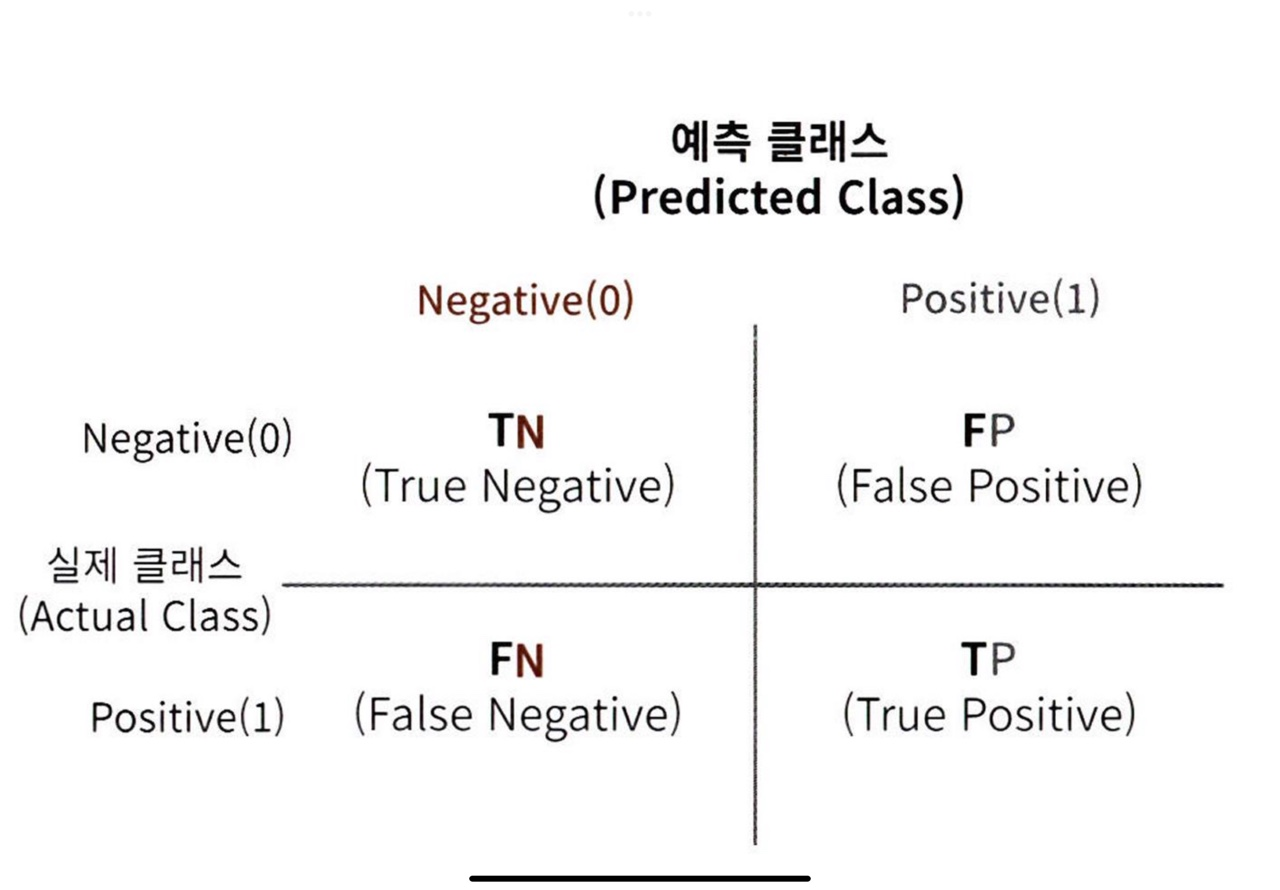

TN은 True Negative의 의미이고 

앞의 True는 예측 클래스 값과 실제 클래스 값이 같다

Begative는 예측값이 Negative값이라는 의미이다. 

즉 TN = 예측을 negative로 했는데 실제값도 negative값 0 이라는 의미임.

* FP : 예측값을 P 값 1로, 실제값은 N값 0
* FN : 예측값을 N값 0로, 실제값은 P 값 1
* TP : 예측값을 P 값 1로, 실제값은 P 값 1
* FN : 예측값을 N값 0로, 실제값은 N값 0


---
사이킷런은 오차행렬을 구하기 위해 confusion_matrix() 를 제공함.


In [9]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, fakepred)

#출력된 오차행렬은 ndarray형태이다. 

array([[405,   0],
       [ 45,   0]])

해석 : TN은 array[0,0]로 405인 것이다. 전체 405건 데이터 중 무조건 Negative 0으로 예측해서 true가 된 결과 405건.


앞 절의 MyFakeClassifier는 load_digits()에서 target==7인지 아닌지에 따라 클래스 값을 True/False 이진 분류로 변경한 데이터 세트를 사용해 무조건 Negative로 예측하는 Classifier였고 테스트 데이터 세트의 클래스 값 분포는 0이 405건, 1이 45건이다. 


-> 이 값들을 조합하여 classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있다. 

정확도 = (TN + TP) / (TN + FP + FN + TP)


---

## 03 정밀도와 재현율

positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다. 
앞서 만든 MyFakeClassifier는 Positive로 예측한 tp값이 하나도 없기 때문에 정밀도와 재현율 값이 모두 0이다.

* **정밀도= TP/ (FP + TP)**

-정밀도는 예측을 Positive로 한 대상 중에 예측과 실제 값이 일치한 데이터의 비율을 뜻한다. 


* **재현율= TP/ (FN + TP)**

-재현율은 실제 값이 Positive인 대상 중에 에측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다. 민감도 또는 TPR이라고도 불림.

[어떤 것이 더 우선인지]

* 재현율이 중요 지표인 경우 : 실제 Positive양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.

* 정밀도가 중유한 경우 : 실제 Negative음성인 데이터 예측을 Positive양성으로 잘못 판단하게 되어 업무상 영향이 발생하는 경우

-> 재현율과 정밀도 모두 높은 수치를 얻는 것이 좋은 성능평가이다. 


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도:{0:.4}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
from google.colab import drive
drive.mount('/content/drive')
titanic_df =pd.read_csv('/content/drive/MyDrive/titanic_train.csv')

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


결과: 정밀도에 비해 재현율이 낮게 나왔다. 재현율 또는 정밀도를 좀 더 강화할 방법은?

### 정밀도/재현율 프레이드오프

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임걔값을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.

하짐나 정밀도와 재현율은 상호 보완적인 평가지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.

이를 정밀도/재현율의 프레이드오프라고 부른다.

------
사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다. 그리고 예측 확률이 큰 레이블값으로 예측하게 된다.

`predict_proba() : 개별 데이터별로 예측 확률을 반환하느 메서드`

* 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하고 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환한다. 반환 결과가 예측 겨로가 클래스 값이 아닌 예측 확률 결과이다.


* 입력 파라미터 : predict() 메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력

* 반환 값: 개별 클래스의 예측 확률을 ndarray m x n (m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환한다.

각 열은 개별 클래스의 예측 확률이고 이진 분류에서 첫번째 칼럼은 - Negative의 확률, 두번째 칼럼은 1 positive의 확률이다.

In [19]:
pred_proba = lr_clf.predict_proba(X_test)
pred - lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array 에서 앞 3개만 샘프로 추출 \n:',pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array 에서 앞 3개만 샘프로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


결과: 0과 1에 대한 확률을 나타내므로 첫번째 칼럼값과 두번째 칼럼값을 더하면 1이 된다. 


---


predict() 는 pred_proba 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값( ex 0.5) 을 만족하는 ndarray의 칼럼 위치를 최정 얘측 클래스로 결정한다.

이러한 구현을 위해 사이킷런의 Binarizer클래스를 이용한다.
먼저 <Binarizer클래스 사용법> 부터 알아보자.

### **<Binarizer클래스 사용법>**

In [21]:
from sklearn.preprocessing import Binarizer

X=[[1,-2,2], [2,0,0],[0,1.1,1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


입력된 X데이터 세트에서 Binarizer의 threshold값이 1.1보다 같거나 작으면 0, 크면 1로 변환됨을 알 수 있다.

이제 이 것을 이용해 사이킷런 predict()의 의사코드를 만들어 보자. 

바로 앞 예제의 LogisticRegression 객체의 predict_proba() 메서드로 구한 각 클래스별 예측 확률값인 pred_proba 객체 변수에 분류 결정 임계값을 0.5로 지정한  Binarizer 클래스를 적용해 최종 예측값을 구하는 방식이다.



In [22]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

#predict_proba() 반환값의 두번재 칼럼, 즉 positive클래스 칼럼 하나만 추출해  Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer= Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)


오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


-> predict 가   predict_proba()를 기반하고 있다는 것을 알 수 있다. 

In [23]:
# Binarizer의 threshold설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer= Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361


임계값을 낮추니 재현율 값이 올라가고 정밀도가 떨어졌다. 이유는 분류 결정 임걧값은 positive예측값을 결정하는 확률의 기준이 된다. 확률이 0.5가 아닌 0.4부터 positive로 예측을 너그럽게 하기 때문에 임곗값 값을 낮출수록 True값이 많아지게 된다.

In [25]:
# 함수를 만들어서 임걧값을 변화하며 평가 지표를 조사해보자.

#테스트를 수행할 모든 임걧값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #threshold list객체 내의 값을 차례로 iteration하면서 evaluation수행
  for custom_threshold in thresholds:
    binarizer= Binarizer(threshold=custom_threshold).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print('임곗값:',custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377


- precision_recall_curve() API

<입력 파라미터>

y_true : 실제 클래스 값 배열 (배열 크기 = [데이터 건수])
probas_pred : Positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수])

<반환 값>

정밀도: 임곗값별 정밀도 값을 배열로 반환
재현율: 임곗값별 재현율 값을 배열로 반환

In [28]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))
 
#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


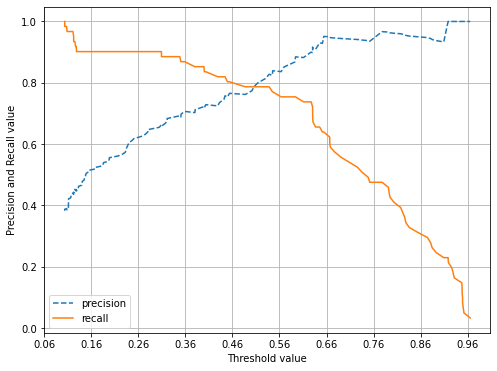

In [32]:
# 곡선으로 시각화해보자.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  #X축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--', label ='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  #x축, y축 label과 legend, 그리고 grid설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

결과: 임계값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상이 된다. 앞 예제의 로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임곗값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 모습을 보임


---

### 정밀도와 재현율이ㅡ 맹점
positive예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다. 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안 된다. 

- 정밀도 100%가 되는 방법

확실하 닉준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측합니다. 예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 다른 경우는 Negative로 예측하는 거다.

- 재현율 100%가 되는 방법

모든 환자를 Positive로 얘측하면 된다. 재현율은 = TP/ (TP+FN)이므로 전체 환자 1000명을 다 pOSITIVE로 예측하는 거다. 이 중 실제 양성인 사람이 30명 정도라도 tn이 수치에 포함되지 않고 fn은 아예 0이므로 100%가 된다.


이처럼 정밀도와 재현율 성능 수치도 어느 한족만 참조하면 극단적인 수치 조작이 가능하다. 따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 ㅜㅂㄴ류로 간주할 수 있다. 둘 중 하나만 강조하는 상항외 돼서는 안됨.



---

### 04 F1 스코어

정밀도와 재현율을 결합한 지표 

어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

사이킷런 제공 API : f1_score()


In [ ]:
from sklearn.metrics import f1_score
f1= f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

In [35]:

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  #F1 스코어 추가
  f1 = f1_score(y_test , pred)
  print('오차행렬')
  print(confusion)
  #f1 score print추가
  print('정확도:{0:.4}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall,f1))

thresholds= [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377


결과 : 0.6일때 가장 좋은 값을 보여준다. 하지만 임곗값이 0.6인 경우에는 재현율이 크게 감소하고 있으니 주지해야한다.



---

### 05 ROC곡선과 AUC

* 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표
* FPR(FALSE POSITIVE RATE)이 변할 때 TPR(재현율=민감도)이 어떻게 변하는지를 나타내는 곡선
* 직선에 가까울수록 성능이 떨어지고 멀어질수록 성능이 뛰어나다.

사이킷런 API : roc_curve()

-입력 파라미터 

* y_true : 실제 클래스 값 array (array shape= [데이터 건수]

* y_score : predict_proba()의 반환 값 array에서 positive칼럼의 예측 확률이 보통 사용됨. array.shape = [n_samples]

-반환 값 : array로 반환



+ 민감도에 대응하는 지표 TNR(특이성)

<정리>
* 민감도(TPR)는 실제값 P양성이 정확히 예측 돼야 하는 수준을 나타낸다. ( 질병 ㅇ 테스트 ㅇ)

* 특이성(TNR)은 실제값 N음성이 정확히 예측돼야하는 수준을 나타낸다.( 질병X 테스트도 음성)

<식>

TNR = TN / (FP + TN)

FPR = FP/ (FP + TN) = 1- 특이성



In [36]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
#thredsholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))
 
#5 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 FPR:', np.round(precisions[thr_index],3))
print('샘플 임계값별 TPR:', np.round(recalls[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값별 FPR: [0.385 0.393 0.428 0.436 0.449 0.451 0.47  0.491 0.519 0.545 0.573]
샘플 임계값별 TPR: [0.984 0.967 0.967 0.951 0.934 0.902 0.902 0.902 0.902 0.902 0.902]


결과 : 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커진다. 이것이 커질 때 TPR은 가파르게 커짐을 알 수 있다. 

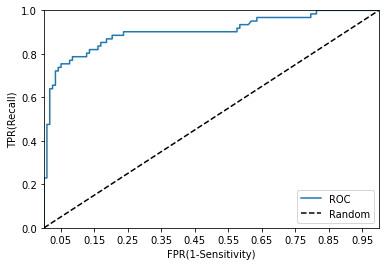

In [39]:
def roc_curve_plot(y_test, pred_proba_c1):
  #임곗값에 따른 fpr, tpr 값을 반화받음.
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  #ROC곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label='ROC')
  #가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k--', label='Random')

  #FPR X축의 scale을 0.1 단위로 변경,  x, y 축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

결과 : 일반적으로 ROC곡선 자체는 FPR과 TPR의 변화 값을 보고, 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC값으로 결정한다.

**AUC 값 : ROC 곡선 밑의 면적을 구한 것**

* 1에 가까울수록 좋은 수치이다.
* AUC가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print("정확도:", np.round(accuracy_score(y_test, pred),4))
print("정밀도:", np.round(precision_score(y_test, pred),4))
print("재현율:", np.round(recall_score(y_test, pred),4))

[[104  14]
 [ 13  48]]
정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869


타이타닉 생존자 예측 로지스틱 회귀 모델의 roc auc 값은 약 0.8987로 측정됨.

밑에 함수는 ROC, AUC 값까지 출력할 수 있다.

In [42]:

def get_clf_eval(y_test, pred):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)

  #ROC-AUC추가
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1, roc_auc))